In [1]:
%matplotlib inline
import sys
import os
import argparse
import time
import numpy as np
sys.path.append('../')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import easydict as edict

from lib import models, datasets
import math

In [2]:
args = edict
args.cache = '../checkpoint/train_features_labels_cache/colorization_embedding_128.t7'
args.save_path = '../checkpoint/pseudos/colorization_128_knn_pseudo_labels_wrn-28-2'
os.makedirs(args.save_path, exist_ok=True)

args.num_class = 10
args.rng_seed = 0

In [3]:
train_features = torch.load(args.cache)
train_labels = torch.Tensor(datasets.CIFAR10Instance(root='../data', train=True).targets).long()

print(train_features.dtype, train_labels.dtype)
print(train_features.shape, train_labels.shape)

torch.float32 torch.int64
torch.Size([50000, 128]) torch.Size([50000])


# use cpu because the following computation need a lot of memory

In [4]:
device = 'cpu'
train_features, train_labels = train_features.to(device), train_labels.to(device)

In [5]:
num_train_data = train_labels.shape[0]
num_class = torch.max(train_labels) + 1

torch.manual_seed(args.rng_seed)
torch.cuda.manual_seed_all(args.rng_seed)
perm = torch.randperm(num_train_data).to(device)
print(perm)

tensor([36044, 49165, 37807,  ..., 42128, 15898, 31476])


# KNN pseudo

num_labeled=  50, prec=45.31, AUC=57.32
num_labeled= 100, prec=50.76, AUC=67.61
num_labeled= 250, prec=57.15, AUC=75.48
num_labeled= 500, prec=60.42, AUC=79.34
num_labeled=1000, prec=61.66, AUC=80.70
num_labeled=2000, prec=62.63, AUC=82.14
num_labeled=4000, prec=64.73, AUC=83.66
num_labeled=8000, prec=65.89, AUC=84.79


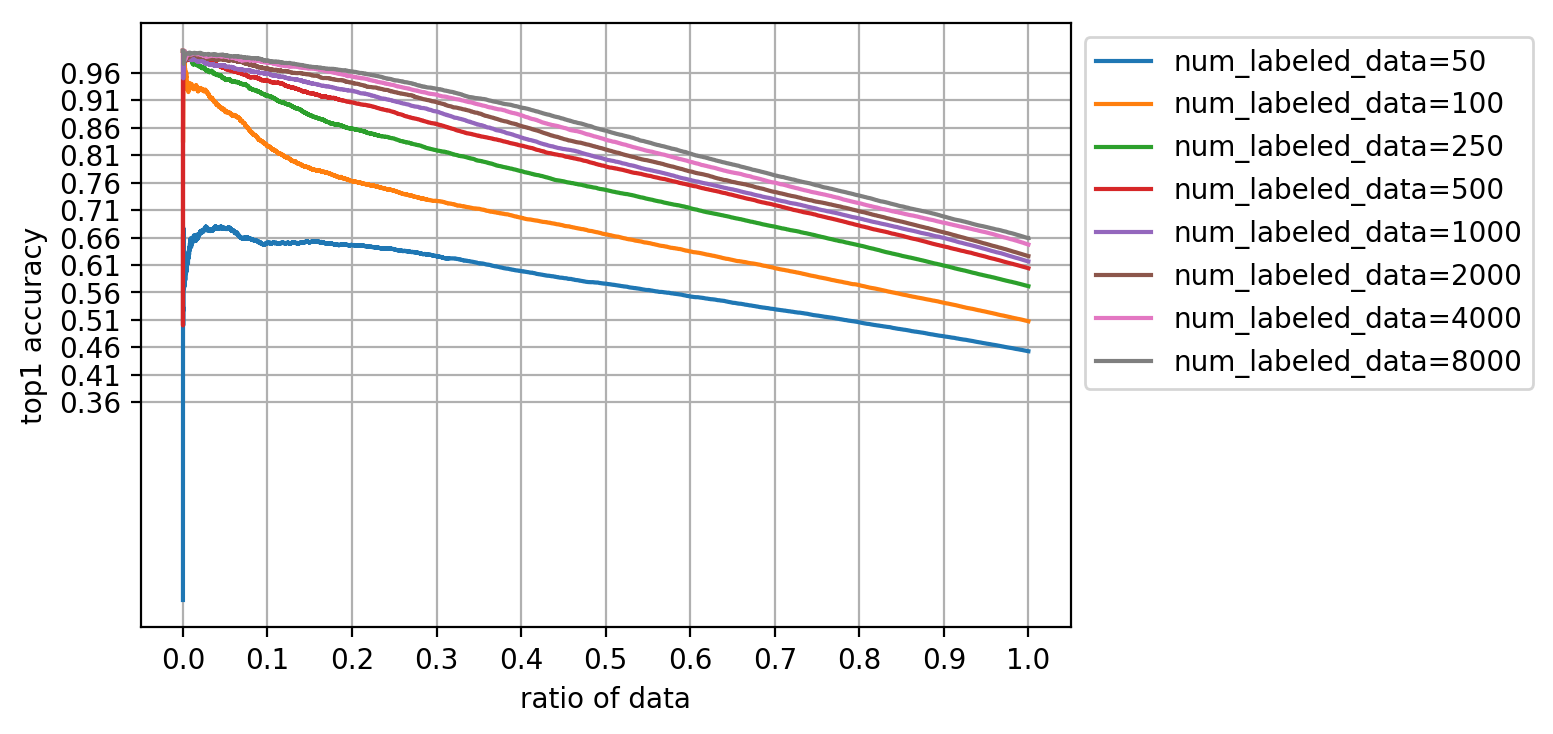

In [6]:
fig = plt.figure(dpi=200)
for num_labeled_data in [50, 100, 250, 500, 1000, 2000, 4000, 8000]:
        # even split
    index_labeled = []
    index_unlabeled = []
    data_per_class = num_labeled_data // args.num_class
    for c in range(10):
        indexes_c = perm[train_labels[perm] == c]
        index_labeled.append(indexes_c[:data_per_class])
        index_unlabeled.append(indexes_c[data_per_class:])
    index_labeled = torch.cat(index_labeled)
    index_unlabeled = torch.cat(index_unlabeled)

#     index_labeled = perm[:num_labeled_data]
#     index_unlabeled = perm[num_labeled_data:]

    # calculate similarity matrix
    dist = torch.mm(train_features, train_features[index_labeled].t())
    dist[index_labeled, torch.arange(num_labeled_data)] = 0

    K = min(num_labeled_data, 200)
    yd, yi = dist.topk(K, dim=1, largest=True, sorted=True)
    candidates = train_labels.view(1,-1).expand(num_train_data, -1)
    retrieval = torch.gather(candidates, 1, index_labeled[yi])

    retrieval_one_hot = torch.zeros(num_train_data * K, num_class).to(device)
    retrieval_one_hot.scatter_(1, retrieval.view(-1, 1), 1)

    temperature = 0.1

    yd_transform = (yd / temperature).exp_()
    probs = torch.sum(torch.mul(retrieval_one_hot.view(num_train_data, -1 , num_class), yd_transform.view(num_train_data, -1, 1)), 1)
    probs.div_(probs.sum(dim=1, keepdim=True))
    probs_sorted, predictions = probs.sort(1, True)
    correct = predictions.eq(train_labels.data.view(-1,1))

    confidence = probs_sorted[:, 0] # - probs_sorted[:, 1]
    
    correct = correct[index_unlabeled, :]
    confidence = confidence[index_unlabeled]
    
    n = confidence.shape[0]
    arange = 1 + np.arange(n)
    idx = confidence.sort(descending=True)[1]
    correct_sorted = correct[idx, 0].numpy()
    accuracies = np.cumsum(correct_sorted) / arange
    xs = arange / n

    plt.plot(xs, accuracies, label='num_labeled_data={}'.format(num_labeled_data))
    
    acc = correct[:, 0].float().mean()

    print('num_labeled={:4}, prec={:.2f}, AUC={:.2f}'.format(
        num_labeled_data, acc * 100, accuracies.mean() * 100))
    
    # save pseudo labels
    unlabeled_probs_top1, unlabeled_indexes_top1 = probs_sorted[:, 0][index_unlabeled].sort(0, True)
    pseudo_indexes = index_unlabeled[unlabeled_indexes_top1]
    pseudo_labels = predictions[index_unlabeled, 0][unlabeled_indexes_top1]
    pseudo_probs = probs[index_unlabeled][unlabeled_indexes_top1]
    assert torch.all(pseudo_labels == pseudo_probs.max(1)[1])
    
    save_dict = {
        'pseudo_indexes': pseudo_indexes,
        'pseudo_labels': pseudo_labels,
        'pseudo_probs': pseudo_probs,
        'labeled_indexes': index_labeled,
        'unlabeled_indexes': index_unlabeled,
    }
    torch.save(save_dict, os.path.join(args.save_path, '{}.pth.tar'.format(num_labeled_data)))
    
plt.xlabel('ratio of data')
plt.ylabel('top1 accuracy')
plt.xticks(np.arange(0, 1.05, 0.1))
plt.yticks(np.arange(0.36, 1.01, 0.05))
plt.grid()
legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()